In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
# g encoded as 1, b encoded as -1
data = np.loadtxt("ionosphere.data", delimiter = ",") # load data
y = data[:,34] # Labels 
X = data[:, 0:34] # Features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=150/351, random_state=120) # Test size set according to table 1 section 5

#For doing the correct grid of gamma's compute pairwise distances between all points in training data,
from scipy.spatial import distance_matrix

# Split dataset into -1,1 to compute pairwise distances for the gamma seed
X_train_1 = X_train[np.where(y_train>0)] # labels 1
X_train_neg1 = X_train[np.where(y_train<0)] # labels -1
dists = distance_matrix(X_train_neg1, X_train_1) # Distance matrix between points

G = np.array(np.min(dists, axis = 1)) # Min over cols
G = np.append(G, np.min(dists, axis = 0)) # min over rows


gamma_J = 1/(2*np.median(G)**2) # Gamma_j
print(gamma_J)


c:\Users\asr\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.12946519529051026


In [2]:
# First train a cross-validated SVM on all of the training data
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from time import time
gauss_svm = SVC(kernel="rbf") # Initialize gaussian SVM 
C_grid = np.logspace(-3, 3, 7) # Values of C to try in CV
gamma_grid = gamma_J*np.array([10**(-4),10**(-2),10**(0),10**(2),10**(4)]) # Values of gamma to try in CV
paramgrid = {"C":C_grid,"gamma":gamma_grid} # Setup parametergrid for cross-validation
t0 = time() # Start timer
gaussian_cv = GridSearchCV(gauss_svm, param_grid=paramgrid, scoring="accuracy") # Init gridsearch using parametergrid
gaussian_cv.fit(X_train, y_train) # Fit SVM
cv_time = time() - t0 # Time it takes to do cross-validation
cv_test_loss = 1-gaussian_cv.score(X_test,y_test) # Calculate the loss
gaussian_cv.best_estimator_
print(cv_time)

0.8099849224090576


In [3]:
# Want to construct a hypothesis space
# Done by training m hypotheses (SVMs) on r random points from the training data
# That is, sample r points at random and train a SVM on these. Do this m times
# Then validate on n-r points
# In the article r = d+1 is chosen, where d=#features

#First create function to sample r points at random and train a SVM


r = X.shape[1] + 1 # Set r = d+1
n = X_train.shape[0] # Set the number of training points

def sample_r(X, y, C = 10, gamma = gamma_grid):
    r = X.shape[1] + 1 # Set r = d+1
    nrow = X.shape[0] # Get number of rows of training examples

    row_sample_space = np.arange(nrow) # Generate the sample space for examples
    indices = np.random.choice(row_sample_space, r, replace=False) # Sample r indices randomly without replacement

    X_train = X[indices,:] # Generate the training data set
    y_train = y[indices] # generate the training labels
    
    X_test = np.delete(X, indices, axis = 0) # generate test data set
    y_test = np.delete(y, indices) # generate test labels

    gamma = np.random.choice(gamma, 1)[0] #Choose gamma randomly from grid

    gauss_svm = SVC(kernel="rbf", C=C, gamma=gamma) # initialize SVM
    gauss_svm.fit(X_train, y_train) # fit model

    val_loss = 1-gauss_svm.score(X_test, y_test) # Calculate validation loss
    return([gauss_svm, val_loss])

# Compute rho as in equation (7)
def min_rho(weak_classifiers, lamb, n=n, r=r):
    pi_h = 1/(len(weak_classifiers)) # Uniform prior

    val_losses = weak_classifiers[:,1].astype("f") # Return validation losses

    min_loss = np.min(val_losses) # Get min loss 

    numerator = pi_h*np.exp(-lamb*(n-r)*(val_losses - min_loss)) # numerator

    denominator = np.sum(numerator) # denominator

    distribution = numerator/denominator # The distribution that minimizes the bound given lambda

    return(distribution)

# Compute lambda as in equation (8)

def min_lamb(weak_classifiers, rho, delta=0.05, n=n, r=r):
    pi_h = 1/(len(weak_classifiers)) # Uniform prior
    
    val_losses = weak_classifiers[:,1].astype("f") # Return validation losses

    kl = np.sum(rho*np.log(rho/pi_h, where=rho>0)) # KL(rho||pi), notice explicit handling of division by 0

    expected_rho_loss = np.sum(val_losses*rho) # expected loss of rho
    
    lambd = 2/(np.sqrt((2*(n-r)*expected_rho_loss)/(kl + np.log(2*np.sqrt(n-r)/delta))+1)+1) # calculate lambda
    
    return(lambd)


# Function to generate the probability distribution over the hypothesis space

def weight_classifier(m,X,y):
    weak_classifiers = np.array([sample_r(X, y) for i in range(m)]) # Create list of weak classifier

    lamb = 1 # know that lambda must be less than one (right under eq(8))

    rho = min_rho(weak_classifiers=weak_classifiers, lamb = lamb)

    lamb_dist = 1

    while(lamb_dist >0.0001):

        temp = lamb # Previous iteration 

        lamb = min_lamb(weak_classifiers, rho) # Minimize lambda given rho

        rho = min_rho(weak_classifiers, lamb) # Minimize rho given lambda

        lamb_dist = temp-lamb # Calculate distance between Lambdas to declare convergence.

    return([rho], [weak_classifiers[:,0]]) # Return probability distribution over classifiers

# Quick function for calculating the bernoulli kl
def kl(p,q): #define kl-function
    if p == 1 or p == 0: #handle exceptions
        return 0
    return(p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))) # Define kl-function 

# Function for finding the (upper) inverse of the kl-function
# Input Lhat and z, where the inverse kl-function given Lhat is calculated at z

def klinverse_upper(Lhat, z):
    low = Lhat # Initialise lowest and highest possible solutions
    high = 1
    while(high - low > 0.0000001): # Set tolerance to 0.0000001
        mid = (high + low)/2 # Find midpoint
        if(kl(Lhat, mid) <= z): # Test if kl() evaluated on the average is less than given z
            low = mid #If lower, raise the low value to the mid value
        else:
            high = mid # Else lower the high value to the mid value
    return(low) # Return the low value, for the maximal p where inequality still holds

    

In [4]:
#Function for calculating the upper bound in theorem 2, and the empirical loss
def predict(classifier, X,y, delta = 0.05):
    samples = X.shape[0] # Get number of samples

    n_estimators = len(classifier[0][0]) # Get number of hypotheses (m)

    distribution = np.array(classifier[0]).reshape(n_estimators) # define rho as seperate array
    estimators = np.array(classifier[1]).reshape(n_estimators) # definie hypothesis as array

    sample_hypothesis = np.random.choice(estimators, size = samples, p = distribution, replace=True) # Sample a hypothesis for every point
    
    sum = 0 
    for i in range(samples):
        sum = np.sum((sample_hypothesis[i].predict([X[i,:]]) !=y[i])) + sum # Calculate loss on each point
    test_loss = sum/samples #calculate the test-loss

    kl = np.sum(distribution*np.log(distribution/(1/n_estimators), where=distribution>0)) # KL(rho||pi), notice explicit handling of division by 0
    bound_RHS = (kl + np.log(2*np.sqrt(samples)/delta))/(samples) # calculate RHS of theorem 2
    bound = klinverse_upper(test_loss, bound_RHS) # calculate the bound

    return(np.array([test_loss,bound]))



In [5]:
# Calculate the test loss and training time of the stochastic classifier for different m
b = np.empty(shape=(1,4))
for t in range(60): # Do experiment n times
    for m in range(1, 200,3): # loop over m's
        t0 = time() # start timing
        classifier = weight_classifier(m,X_train, y_train) # train classifier
        training_time = time()-t0 # 
        predictions = predict(classifier, X_test, y_test)
        test_loss = predictions[0]
        bound = predictions[1]
        new = np.array([[training_time, test_loss, bound,m]])
        b = np.append(b, new, axis = 0)

b = np.delete(b, [0], axis = 0)


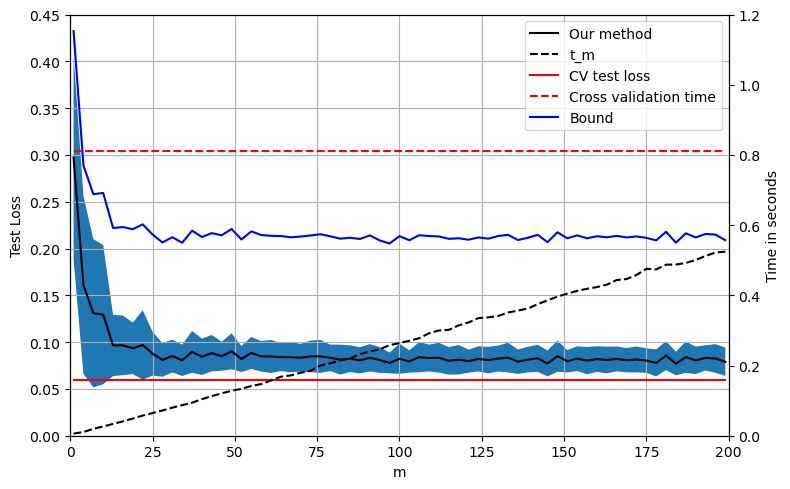

In [8]:
aggregated = np.empty(shape=(1,5))
for i in np.unique(b[:,3]): # loop over unique indicies
    tmp = b[np.where(b[:,3] == i)] # Have only rows with relevant index
    means = np.array([[np.mean(tmp[:,0]), np.mean(tmp[:,1]),np.mean(tmp[:,2]), i,np.std(tmp[:,1])]]) # Calculate mean of training time and loss in each group
    aggregated = np.append(aggregated, means, axis =0) # append to array
aggregated = np.delete(aggregated, [0], axis = 0) # delete the empty row


import matplotlib.pyplot as plt
fig, host = plt.subplots(figsize=(8,5))
par1 = host.twinx()

host.set_xlim(0, 200)
host.set_ylim(0, 0.45)
par1.set_ylim(0, 1.2)

host.set_xlabel("m")
host.set_ylabel("Test Loss")
par1.set_ylabel("Time in seconds")

p1, = host.plot(aggregated[:,3],aggregated[:,1], label = "Our method", color = "black")
host.fill_between(aggregated[:,3], aggregated[:,1]-aggregated[:,4], aggregated[:,1]+aggregated[:,4])

p2, = par1.plot(aggregated[:,3], aggregated[:,0], label = "t_m", linestyle = "dashed", color = "black")
p3, = host.plot(aggregated[:,3],np.tile(cv_test_loss, reps = len(aggregated)), label = "CV test loss", color = "red")
p4, = par1.plot(aggregated[:,3],np.tile(cv_time, reps = len(aggregated)), label = "Cross validation time", linestyle = "dashed", color = "red")
p5, = host.plot(aggregated[:,3], aggregated[:,2], label = "Bound", color = "blue")


lns = [p1, p2, p3, p4,p5]

host.legend(handles = lns, loc = "best")
host.grid()
#host.yaxis.label.set_color(p1.get_color())
#par1.yaxis.label.set_color(p2.get_color())
fig.tight_layout()
fig.savefig("plot1.png")